In [1]:
%load_ext autoreload
%autoreload 2
from kuepfd import kuepfd as epan
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import jn_zeros, j1, j0
from typing import List
from tqdm import tqdm

# Global Parameters

In [2]:
# Light speed
c  = 2.998*(10**8)
# Frequency
f = 10.7 * (10**9)
# Lambda
lambd = c/f
# Earth radius
earth_radius = 6378.0
# GSO altitude
gso_alt = 35786

# GSO Earth Station Radiation Pattern

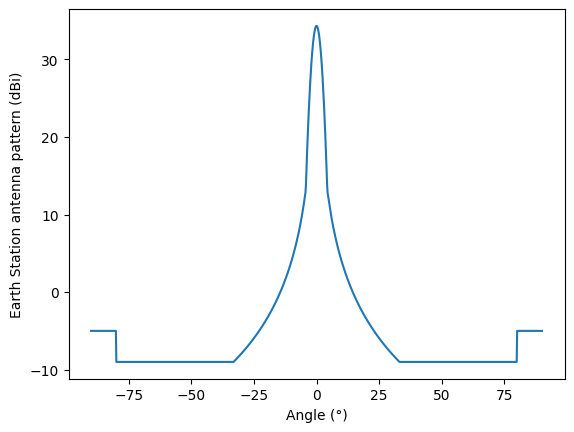

In [3]:
# Earth station antenna pattern -------------------------------------------

# Antenna size
ea_antenna_size = 0.6
# Earth station antenna instance
ea_antenna = epan.EStAnt( ea_antenna_size, lambd )

# Angle axis
th = np.linspace( -np.pi / 2, np.pi / 2, 1000 )
# Antenna pattern
g_itu1428 = np.array( [ ea_antenna.compute_ant_patt( np.rad2deg( thp ) ) for thp in th ] )

# Plot
f1 = plt.figure(1)
plt.plot( np.rad2deg( th ), g_itu1428, label='ITU 1428' )
plt.xlabel( 'Angle (°)' )
plt.ylabel( 'Earth Station antenna pattern (dBi)' )
plt.show()

# Write to file
np.savetxt(f'./results/gso_ea_ant_pattern.txt', np.transpose([th, g_itu1428]) )


# NGSO Satellite Antenna Radiation Pattern

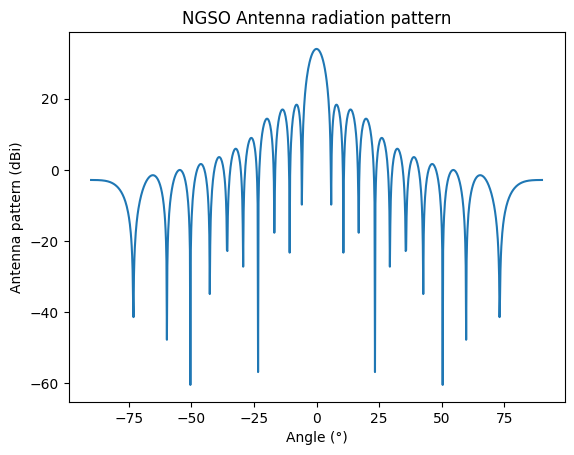

In [4]:
# NGSO Satellite antenna pattern ------------------------------------------

# NGSO antenna size
ngso_antenna_size = 0.15
# Number of secondary lobes
ngso_num_sec_lobes = 4
# Max. gain
ngso_max_gain = 34.0
# Side lobe ratio
ngso_slr = 15.0
# Antenna instance
ngso_antenna = epan.NGSOAnt( ngso_antenna_size, lambd, ngso_num_sec_lobes, ngso_max_gain, ngso_slr )

# Antenna pattern
g_itu1528 = [ ngso_antenna.compute_ant_patt_pp( thp ) for thp in th ]

# Plot
plt.plot( np.rad2deg( th ), g_itu1528 )
plt.xlabel( 'Angle (°)' )
plt.ylabel( 'Antenna pattern (dBi)' )
plt.title( 'NGSO Antenna radiation pattern' )

np.savetxt(f'./results/ngso_ant_pattern_{ngso_num_sec_lobes},{ngso_slr}.txt', np.transpose([th, g_itu1528]) )


# Simulation (1)

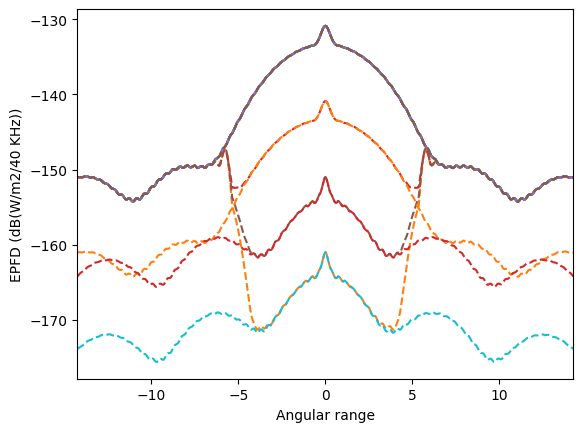

In [6]:
# Number of satellite per plane
num_sat_pp = 1000
# Number of planes 
num_planes = 1
# First plane altitude
f_pl_heigth = 1200.0
# Latitude difference between planes
pl_heigth_dh = 10.0
# NGSO Power (dBW)
ngso_power_dbw = 10.0

# GSO beamwidth
gso_beamwidth = np.deg2rad( 2.5 )
# GSO coverage angular range
ang_range = np.arcsin( ( ( earth_radius + gso_alt ) / earth_radius ) * np.sin( gso_beamwidth ) ) - gso_beamwidth
ang_range_dg = np.rad2deg( ang_range )

# EPFD Threshold
epfd_th = -160

for mit_angle_dg in [10, 30]:
    mit_angle = np.deg2rad( mit_angle_dg )
    
    for power_control_db in np.array([-10, 0]):
        power_control_f = 10**( power_control_db / 10.0 )
        
        for steering_angle_dg in [20,0]:
            steering_angle = np.deg2rad( steering_angle_dg )
    
            eat_axis, epfd_v, epfd_mit, prot_arc_w, prot_arc_mit = epan.eval_interference_sp( num_sat_pp,
                                   num_planes,
                                   ngso_antenna,
                                   ea_antenna,
                                   f_pl_heigth,
                                   pl_heigth_dh,
                                   ngso_power_dbw,
                                   ang_range,
                                   epfd_th,
                                   mit_angle,
                                   steering_angle,
                                   power_control_f,
                                   num_s_samples=1000 )
    
    
            # Plot results
            f2 = plt.figure(2)
            plt.plot( np.rad2deg( eat_axis ) - 90, epfd_v )
            plt.plot( np.rad2deg( eat_axis ) - 90, epfd_mit, linestyle='--' )
            plt.xlabel( 'Angular range' )
            plt.ylabel( 'EPFD (dB(W/m2/40 KHz))' )
            plt.xlim([-ang_range_dg, ang_range_dg])

            np.savetxt(f'./results/fig1_{mit_angle_dg},{power_control_db},{steering_angle_dg}.txt', np.transpose([np.rad2deg( eat_axis ) - 90, epfd_mit]) )
            
np.savetxt(f'./results/fig1_without_mit.txt', np.transpose([np.rad2deg( eat_axis ) - 90, epfd_v]) )



# Simulation (2)

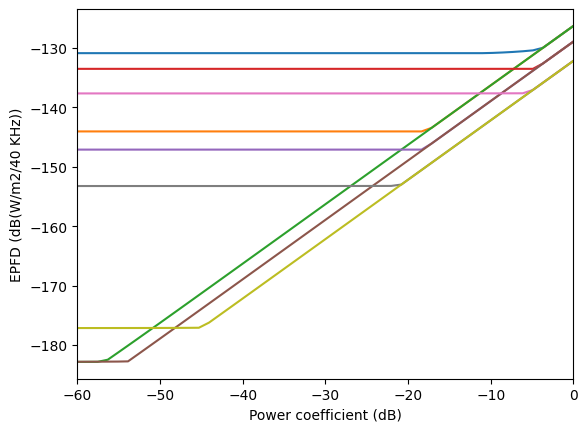

In [59]:
# Number of satellite per plane
num_sat_pp = 2000
# Number of planes 
num_planes = 1
# First plane altitude
f_pl_heigth = 1200.0
# Latitude difference between planes
pl_heigth_dh = 10.0
# NGSO Power (dBW)
ngso_power_dbw = 10.0
# steering angle
steering_angle = 0

# GSO beamwidth
gso_beamwidth = np.deg2rad( 2.5 )
# GSO coverage angular range
ang_range = np.arcsin( ( ( earth_radius + gso_alt ) / earth_radius ) * np.sin( gso_beamwidth ) ) - gso_beamwidth
ang_range_dg = np.rad2deg( ang_range )

# EPFD Threshold
epfd_th = -160
mit_angle_dg = 30
mit_angle = np.deg2rad( mit_angle_dg )

power_c = np.linspace( -60, 0, 50 )
for f_pl_heigth in [500, 1000, 2000]:

    for mit_angle_dg in [5, 20, 30]:
        mit_angle = np.deg2rad( mit_angle_dg )

        max_epfd = []
        for power_control_f_db in power_c:
            power_control_f = 10**( power_control_f_db/10 )
            
            eat_axis, epfd_v, epfd_mit, prot_arc_w, prot_arc_mit = epan.eval_interference_sp( num_sat_pp,
                                   num_planes,
                                   ngso_antenna,
                                   ea_antenna,
                                   f_pl_heigth,
                                   pl_heigth_dh,
                                   ngso_power_dbw,
                                   ang_range,
                                   epfd_th,
                                   mit_angle,
                                   steering_angle,
                                   power_control_f,
                                   num_s_samples=50 )
        
            max_epfd.append( np.max( epfd_mit ) )
            
        # Plot results
        plt.plot( power_c, max_epfd )
        plt.xlabel( 'Power coefficient (dB)' )
        plt.ylabel( 'EPFD (dB(W/m2/40 KHz))' )
        plt.xlim([min(power_c), max(power_c)])

        np.savetxt(f'./results/fig2_{f_pl_heigth},{mit_angle_dg}.txt', np.transpose([ power_c , max_epfd]) )



# Simulation (3)

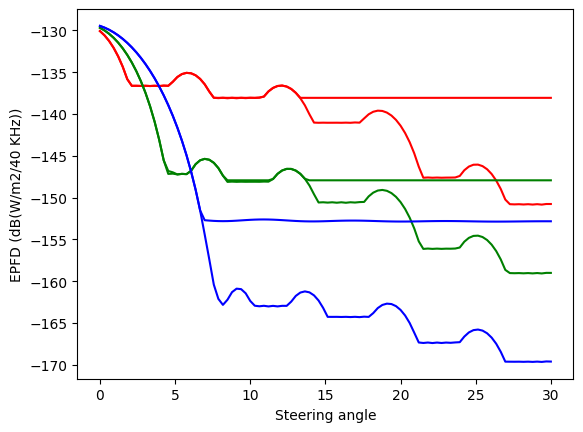

In [71]:
# Number of satellite per plane
num_sat_pp = 2000
# Number of planes 
num_planes = 1
# First plane altitude
f_pl_heigth = 1200.0
# Latitude difference between planes
pl_heigth_dh = 10.0
# NGSO Power (dBW)
ngso_power_dbw = 10.0
# steering angle
steering_angle = 0

# GSO beamwidth
gso_beamwidth = np.deg2rad( 2.5 )
# GSO coverage angular range
ang_range = np.arcsin( ( ( earth_radius + gso_alt ) / earth_radius ) * np.sin( gso_beamwidth ) ) - gso_beamwidth
ang_range_dg = np.rad2deg( ang_range )

# EPFD Threshold
epfd_th = -160
mit_angle_dg = 30
mit_angle = np.deg2rad( mit_angle_dg )

power_control_f = 1.0
steering_angle_dg_v = np.linspace( 0, 30, 100 )

colors = ['r', 'g', 'b']
for i,s in enumerate( [5, 15, 30] ):
    ngso_antenna = epan.NGSOAnt( ngso_antenna_size, lambd, ngso_num_sec_lobes, ngso_max_gain, s )
    
    for mit_angle_dg in [15, 30]:
        mit_angle = np.deg2rad( mit_angle_dg )

        max_epfd = []
        for steering_angle_dg in steering_angle_dg_v:
            steering_angle = np.deg2rad( steering_angle_dg )

            eat_axis, epfd_v, epfd_mit, prot_arc_w, prot_arc_mit = epan.eval_interference_sp( num_sat_pp,
                                   num_planes,
                                   ngso_antenna,
                                   ea_antenna,
                                   f_pl_heigth,
                                   pl_heigth_dh,
                                   ngso_power_dbw,
                                   ang_range,
                                   epfd_th,
                                   mit_angle,
                                   steering_angle,
                                   power_control_f,
                                   num_s_samples=50 )
        
            max_epfd.append( np.max( epfd_mit ) )

        # Plot results
        plt.plot( steering_angle_dg_v, max_epfd, color=colors[i] )
        plt.xlabel( 'Steering angle' )
        plt.ylabel( 'EPFD (dB(W/m2/40 KHz))' )
        # plt.xlim([min(power_c), max(power_c)])

        np.savetxt(f'./results/fig3_{s},{mit_angle_dg}.txt', np.transpose([ steering_angle_dg_v , max_epfd ]) )



# Simulation (4)

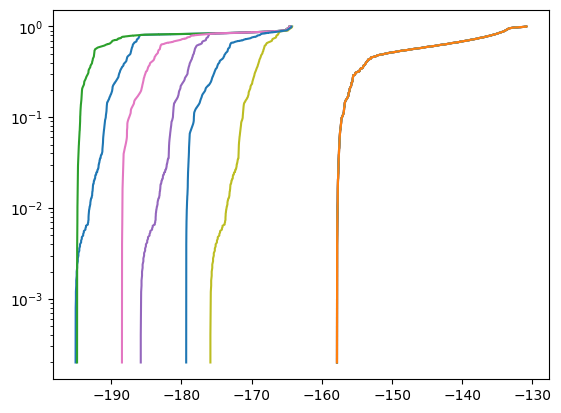

In [96]:
from scipy import stats

ngso_antenna = epan.NGSOAnt( ngso_antenna_size, lambd, ngso_num_sec_lobes, ngso_max_gain, 20 )
# Number of satellite per plane
num_sat_pp = 1000
# Number of planes 
num_planes = 1
# First plane altitude
f_pl_heigth = 1200.0
# Latitude difference between planes
pl_heigth_dh = 10.0
# NGSO Power (dBW)
ngso_power_dbw = 10.0
# steering angle
steering_angle = 0

# GSO beamwidth
gso_beamwidth = np.deg2rad( 2.5 )
# GSO coverage angular range
ang_range = np.arcsin( ( ( earth_radius + gso_alt ) / earth_radius ) * np.sin( gso_beamwidth ) ) - gso_beamwidth
ang_range_dg = np.rad2deg( ang_range )

# EPFD Threshold
epfd_th = -160
mit_angle_dg = 30
mit_angle = np.deg2rad( mit_angle_dg )

colors = ['r', 'g', 'b']

for power_control_f_db in [-30,-20,-10]:
    power_control_f = 10**( power_control_f_db/10.0 )
    
    for steering_angle_dg in [10,20]:
        steering_angle = np.deg2rad( steering_angle_dg )
        
        prot_arc_perc = []
        for mit_angle_dg in [25]:
            mit_angle = np.deg2rad( mit_angle_dg )

            eat_axis, epfd_v, epfd_mit, prot_arc_w, prot_arc_mit = epan.eval_interference_sp( num_sat_pp,
                                   num_planes,
                                   ngso_antenna,
                                   ea_antenna,
                                   f_pl_heigth,
                                   pl_heigth_dh,
                                   ngso_power_dbw,
                                   ang_range,
                                   epfd_th,
                                   mit_angle,
                                   steering_angle,
                                   power_control_f,
                                   num_s_samples=5000 )
            
            res_mit = stats.ecdf(epfd_mit)
            res_w = stats.ecdf(epfd_v)


            
            
            # Plot results
            plt.semilogy( res_mit.cdf.quantiles, res_mit.cdf.probabilities )
            plt.semilogy( res_w.cdf.quantiles, res_w.cdf.probabilities )
            

            np.savetxt(f'./results/fig4_{power_control_f_db},{steering_angle_dg}.txt', np.transpose([ res_mit.cdf.quantiles, res_mit.cdf.probabilities ]) )
            
np.savetxt(f'./results/fig4_w.txt', np.transpose([ res_w.cdf.quantiles, res_w.cdf.probabilities ]) )

